In [1]:
# Import modules and subroutines:
include("../subroutines/Subroutines.jl");

3.10.9


In [33]:
# Load the pyscf data into Julia:

md_fname = "Be2_sto3g_010924%1407.hdf5"
chemical_data_list = ReadIn("../datasets/pyscf_data/"*md_fname)
PrintChemData(chemical_data_list[1])
bond_lengths = [i/10 for i=5:30];

Molecule name: Be2
Basis set: sto3g
Molecular geometry: ../configs/xyz_files/Be2/0.5.xyz
RHF energy: -25.876964830062686
FCI energy: -25.989067463459588


In [34]:
e_rhf_vec = [chemical_data_list[m].e_rhf for m=1:length(chemical_data_list)]
e_fci_vec = [chemical_data_list[m].e_fci for m=1:length(chemical_data_list)];

In [13]:
gp = GeomParameters(
    maxiter=30000,
    eta=-2,
    shrp=2.0,
    a_alpha=1e0
)

GeomParameters
  maxiter: Int64 30000
  afunc: String "stun"
  a_alpha: Float64 1.0
  a_gamma: Float64 100.0
  swap_mult: Float64 3.0
  a_tpow: Float64 5.0
  cweight: Float64 1.0
  eta: Int64 -2
  shrp: Float64 2.0
  anchor: Int64 0
  return_all: Bool false


In [16]:
# A DMRG test:

maxdims = [4,10,16,30]

e_dmrg_vecs = [[],[],[],[]]

sweep_objects = [
    Sweeps(10, maxdim=4, noise=(1e-3,1e-4,1e-5,1e-6,1e-7)),
    Sweeps(10, maxdim=10, noise=(1e-3,1e-4,1e-5,1e-6,1e-7)),
    Sweeps(10, maxdim=16, noise=(1e-3,1e-4,1e-5,1e-6,1e-7)),
    Sweeps(10, maxdim=30, noise=(1e-3,1e-4,1e-5,1e-6,1e-7))
]

for m=1:length(chemical_data_list)
    
    chemical_data = chemical_data_list[m]
    
    fci_array = FCIArray(chemical_data)
    fci_mps = MPS(fci_array, siteinds("Electron", 10), cutoff=1e-16, maxdim=2^16);
    
    S1, S2, Ipq = MutualInformation(fci_mps, collect(1:chemical_data.N_spt), chemical_data)
    
    opt_ord = InfDistAnnealing(
        Ipq, 
        1, 
        gp,
        verbose=true
    )[1]
    
    for k=1:4
    
        dmrg_k = GenSubspace(
            chemical_data, 
            1, 
            psi_maxdim=maxdims[k], 
            dflt_sweeps=sweep_objects[k]
        );

        dmrg_k.ord_list = [deepcopy(opt_ord)]

        GenHams!(dmrg_k)
        GenStates!(dmrg_k, verbose=true)
        GenPermOps!(dmrg_k)
        GenSubspaceMats!(dmrg_k)
        SolveGenEig!(dmrg_k)
        
        e_fin = inner(dmrg_k.psi_list[1]', dmrg_k.ham_list[1], dmrg_k.psi_list[1])
        
        push!(e_dmrg_vecs[k], e_fin)
        
    end
    
    println("\n$(m)/$(length(chemical_data_list))\n")
    
end

Generating states:6    
Progress: [1/1] 
Done!
Generating states:
Progress: [1/1] 
Done!
Generating states:
Progress: [1/1] 
Done!
Generating states:
Progress: [1/1] 
Done!

1/26

Generating states:6    
Progress: [1/1] 
Done!
Generating states:
Progress: [1/1] 
Done!
Generating states:
Progress: [1/1] 
Done!
Generating states:
Progress: [1/1] 
Done!

2/26

Generating states:8    
Progress: [1/1] 
Done!
Generating states:
Progress: [1/1] 
Done!
Generating states:
Progress: [1/1] 
Done!
Generating states:
Progress: [1/1] 
Done!

3/26

Generating states:3    
Progress: [1/1] 
Done!
Generating states:
Progress: [1/1] 
Done!
Generating states:
Progress: [1/1] 
Done!
Generating states:
Progress: [1/1] 
Done!

4/26

Generating states:1    
Progress: [1/1] 
Done!
Generating states:
Progress: [1/1] 
Done!
Generating states:
Progress: [1/1] 
Done!
Generating states:
Progress: [1/1] 
Done!

5/26

Generating states:     
Progress: [1/1] 
Done!
Generating states:
Progress: [1/1] 
Done!
Generating 

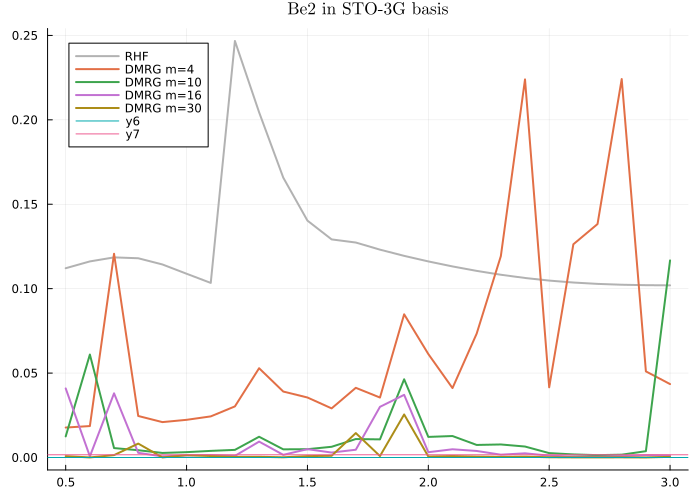

In [43]:
xl=[1,26]

plt = plot(
    bond_lengths[xl[1]:xl[2]], 
    e_rhf_vec[xl[1]:xl[2]].-e_fci_vec[xl[1]:xl[2]], 
    color=RGB(0.7,0.7,0.7), 
    linewidth=2.0,
    label="RHF",
    title="Be2 in STO-3G basis",
    titlefontsize=11.0,
    titlefont=font(14,"Computer Modern"),
    #xguide=L"r\quad(\AA)",
    #yguide=L"E\quad(\textrm{Ha.})",
    size=(700,500)
)

"""
plot!(
    bond_lengths[xl[1]:xl[2]], 
    e_fci_vec[xl[1]:xl[2]], 
    label="FCI",
    color=RGB(0.0,0.0,0.0),
    linewidth=2.0
)
"""

e_nuc_vec = [cdata.e_nuc for cdata in chemical_data_list]

for k=1:4
    plot!(
        bond_lengths[xl[1]:xl[2]], 
        abs.(e_dmrg_vecs[k][xl[1]:xl[2]].+e_nuc_vec[xl[1]:xl[2]].-e_fci_vec[xl[1]:xl[2]]), 
        label="DMRG m=$(maxdims[k])",
        linewidth=2.0
    )
end

hline!([0.0])
hline!([0.0016])

display(plt)

In [ ]:
"""
for k=1:4
    plot!(
        bond_lengths, 
        e_dmrg_vecs[k].+e_nuc_vec, 
        label="DMRG m=$(maxdims[k])",
        linewidth=2.0
    )
end
"""

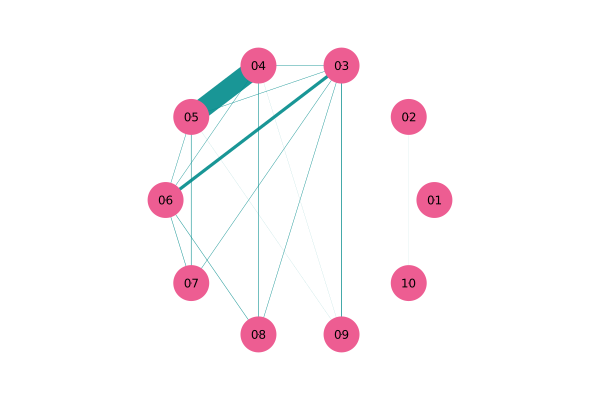

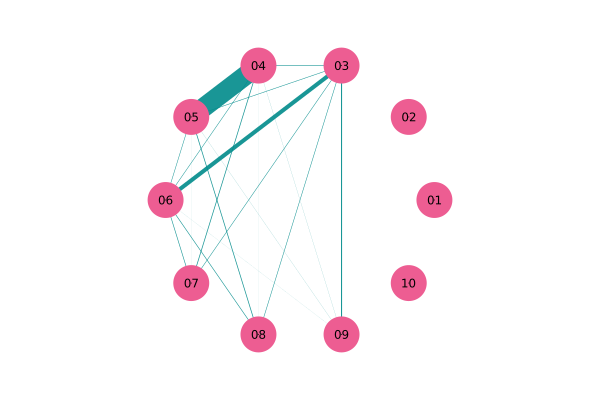

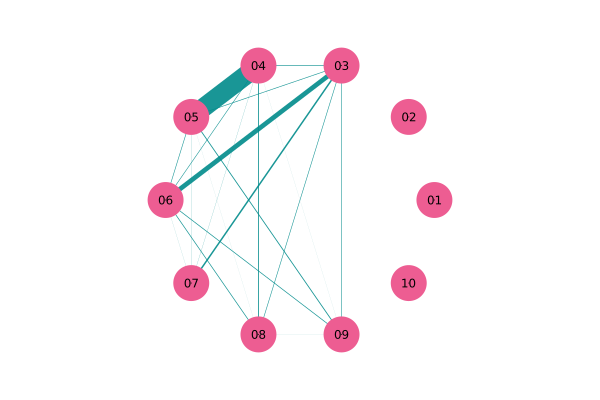

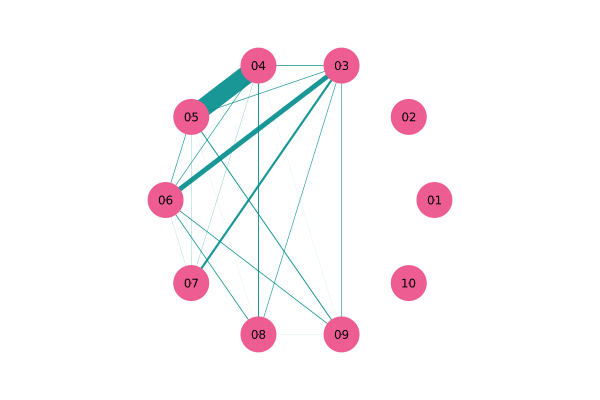

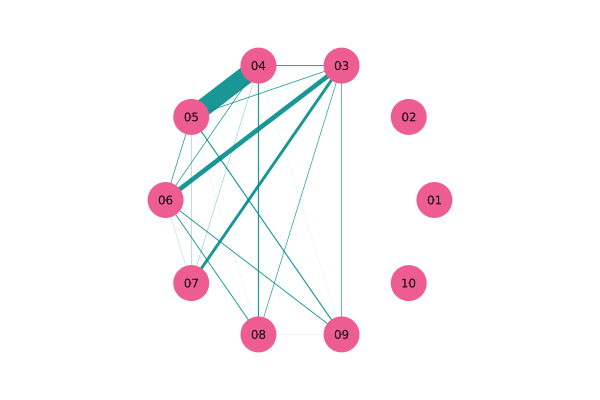

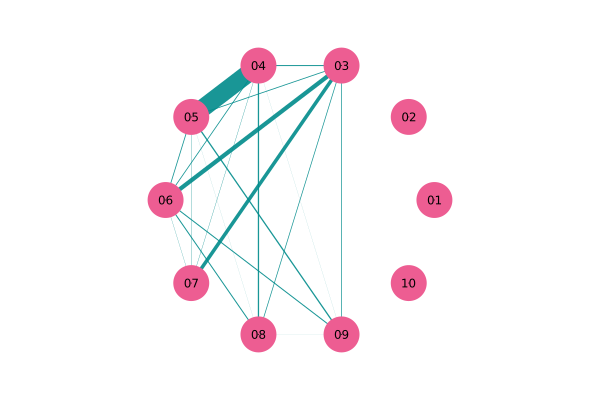

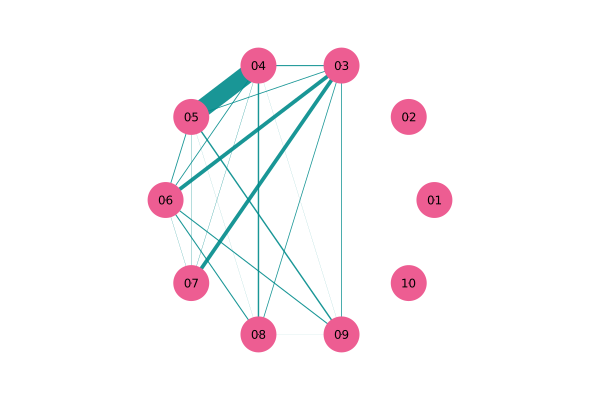

LoadError: InterruptException:

In [44]:
for m=1:length(chemical_data_list)
    
    chemical_data = chemical_data_list[m]
    
    fci_array = FCIArray(chemical_data)
    fci_mps = MPS(fci_array, siteinds("Electron", 10), cutoff=1e-16, maxdim=2^16);
    
    S1, S2, Ipq = MutualInformation(fci_mps, collect(1:chemical_data.N_spt), chemical_data)
    
    OrbitalGraphPlot(Ipq, multiplier=1.5e1)
    
end